# 🧠 LoRA Fine-Tuning for English–German Translation using DistilGPT2

This project demonstrates **efficient fine-tuning of a lightweight language model** (DistilGPT2) using **LoRA (Low-Rank Adaptation)** for **English-to-German translation**. It is designed to work even in **low-resource environments** like Google Colab by using **8-bit quantization**, **FP16**, and a **sampled dataset**.

## 📌 Key Objectives

- 🏋️‍♂️ Fine-tune a causal language model (DistilGPT2) for translation
- ⚡ Use **LoRA** to reduce training time and memory usage
- 🔍 Apply **8-bit quantization** and **mixed precision training**
- 📝 Work with a parallel English-German dataset (`deu.txt`)
- ✅ Prepare everything for lightweight deployment


## 📁 Data Preprocessing

The dataset is a **tab-separated file (`deu.txt`)** containing parallel English-German sentence pairs. A **sample fraction** is used to reduce memory during training.

### Sample Format (deu.txt):
```
I love you.    Ich liebe dich.
How are you?   Wie geht es dir?
```

## 🧠 Model Setup & Optimization

### ✅ Model Used:
- `distilgpt2` – a lightweight version of GPT2
- LoRA added for efficient fine-tuning
- Quantized to 8-bit with BitsAndBytes
- Uses FP16 for memory savings



## ⚙️ Training Configuration

| Parameter               | Value          |
|------------------------|----------------|
| Model                  | DistilGPT2 + LoRA |
| Batch Size             | 1 (gradient accumulation of 4) |
| Max Steps              | 300            |
| Learning Rate          | 5e-5           |
| Mixed Precision (fp16) | ✅ Yes          |
| Save Strategy          | No saving      |

We used the **Trainer API** from Hugging Face for simplicity and integrated it with our custom collator and LoRA-injected model.



## 🚀 How to Run

1. Upload `deu.txt` to your environment.
2. Run the full Python script.
3. Training will begin and complete in ~5–10 minutes (depending on GPU).


## 📊 Example Prompt-Output

```text
Prompt:
Translate English to German:
English: How are you?
German:

Output:
Wie geht es dir?
```


In [ ]:
# Install required libraries
!pip install -q transformers datasets accelerate peft bitsandbytes
!pip install gradio
!pip install datasets

In [33]:
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig
)
from datasets import Dataset
from peft import get_peft_model, LoraConfig, TaskType

In [34]:
# Quantization configuration for reduced memory usage (helpful for Colab)
quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,  # Enable 8-bit quantization
    llm_int8_threshold=6.0
)

In [35]:
class FalconWrapper(AutoModelForCausalLM):
    def forward(self, *args, **kwargs):
        # Remove unsupported arguments
        kwargs.pop("num_items_in_batch", None)
        return super().forward(*args, **kwargs)

In [36]:
# Configure model and tokenizer (I am trying distilgpt2 as an alternative for lower GPU usage)
model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

In [37]:
# Load model with quantization and mixed precision
model = FalconWrapper.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")

In [38]:
def load_and_prepare_data(file_path, sample_fraction=0.3):
    raw_lines = []
    # Read all lines
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    # Calculate sample size and slice
    sample_size = int(len(lines) * sample_fraction)
    lines = lines[:sample_size]

    # Process lines into input-output pairs
    for line in lines:
        parts = line.strip().split('\t')
        if len(parts) >= 2:
            raw_lines.append({'input': parts[0], 'output': parts[1]})

    return Dataset.from_list(raw_lines)

In [39]:
# Load and split data (80% train, 20% validation)
dataset = load_and_prepare_data('deu.txt').train_test_split(test_size=0.2, seed=42)

In [ ]:
# Formatting function
def format_dataset(example):
    return {
        "text": f"Translate English to German:\nEnglish: {example['input']}\nGerman:",
        "labels": example['output']
    }

train_dataset = dataset['train'].map(format_dataset)
val_dataset = dataset['test'].map(format_dataset)

In [41]:
# Tokenization with proper padding/truncation
def tokenize_function(examples):
    model_inputs = tokenizer(
        examples["input"],
        max_length=30,
        padding="max_length",
        truncation=True
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["output"],
            max_length=30,
            padding="max_length",
            truncation=True
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
# Apply tokenization
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)

In [43]:
# Remove unnecessary columns
tokenized_train = tokenized_train.remove_columns(["text", "input", "output"])
tokenized_val = tokenized_val.remove_columns(["text", "input", "output"])

### ✅ LoRA Configuration:
```python
LoraConfig(
    r=4,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none"
)
```

In [ ]:
# Configure LoRA (lightweight)
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=4,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none"

)

In [ ]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="lora-falcon-output",
    max_steps=300,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,  # Increase accumulation steps to maintain effective batch size
    learning_rate=5e-5,
    fp16=True,  # Enable mixed precision training
    logging_steps=50,
    save_strategy="no",
    evaluation_strategy="no",
    report_to="none",
    remove_unused_columns=False,
    warmup_steps=10,
    dataloader_num_workers=2  # Increase workers for better I/O throughput
)

In [ ]:
# Data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

In [ ]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator
)

In [ ]:
# Start training
print("Starting training...")
trainer.train()


In [ ]:
# Save the model
model.save_pretrained("lora-falcon-finetuned")
tokenizer.save_pretrained("lora-falcon-finetuned")

**Inference**:
   - Finally, I used the trained model to perform **inference** on a few sample sentences. The model generates the German translation for an English input, which can be evaluated by comparing it to the ground truth translation.

In [ ]:
# Inference function
def generate_translation(model, tokenizer, english_text):
    prompt = f"Translate English to German:\nEnglish: {english_text}\nGerman:"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=50,
            num_beams=5,
            early_stopping=True,
            temperature=0.7
        )

    # Decode only the generated German text
    full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    german_translation = full_output.split("German:")[1].strip()
    return german_translation

In [ ]:
# Test translation
test_text = "Where is the train station?"
translation = generate_translation(model, tokenizer, test_text)
print(f"\nTest Translation:\nEnglish: {test_text}\nGerman: {translation}")

In [ ]:
from transformers import pipeline # Import the pipeline function

# Initialize the translator
translator = pipeline(task="translation", model="lora-falcon-finetuned", tokenizer="lora-falcon-finetuned")

In [ ]:
import gradio as gr

In [ ]:
import gradio as gr
from transformers import pipeline

In [ ]:
# Load the fine-tuned Falcon model with LoRA adapters
translator = pipeline(
    task="translation",
    model="lora-falcon-finetuned",
    tokenizer="lora-falcon-finetuned"
)

In [ ]:
# Define the translation function
def translate_text(text):
    if not text.strip():
        return "Please enter some English text to translate."
    result = translator(text)[0]['translation_text']
    return result

In [ ]:
# Interface styling
title = "🌍 English-to-German Translator"
description = """
🔤 This web application uses a **fine-tuned Falcon-1B model with LoRA (Low-Rank Adaptation)** to translate English sentences into German efficiently.🧠 The model was trained by **Subrat Kumar** with a focus on performance and low GPU consumption using parameter-efficient fine-tuning techniques.📍 Just enter any English sentence below and click **Translate** to get its German equivalent.
"""

In [ ]:
# Launch the Gradio Interface
interface = gr.Interface(
    fn=translate_text,
    inputs=gr.Textbox(
        label="📝 Enter English Text",
        placeholder="Type something like: 'How are you today?'",
        lines=3
    ),
    outputs=gr.Textbox(
        label="🇩🇪 German Translation",
        lines=3
    ),
    title=title,
    description=description,
    theme="soft",  # Optional: switch to a soft color palette
    allow_flagging="never",
    examples=["Good morning!", "What is your name?", "I love machine learning."]
)


In [ ]:
interface.launch()

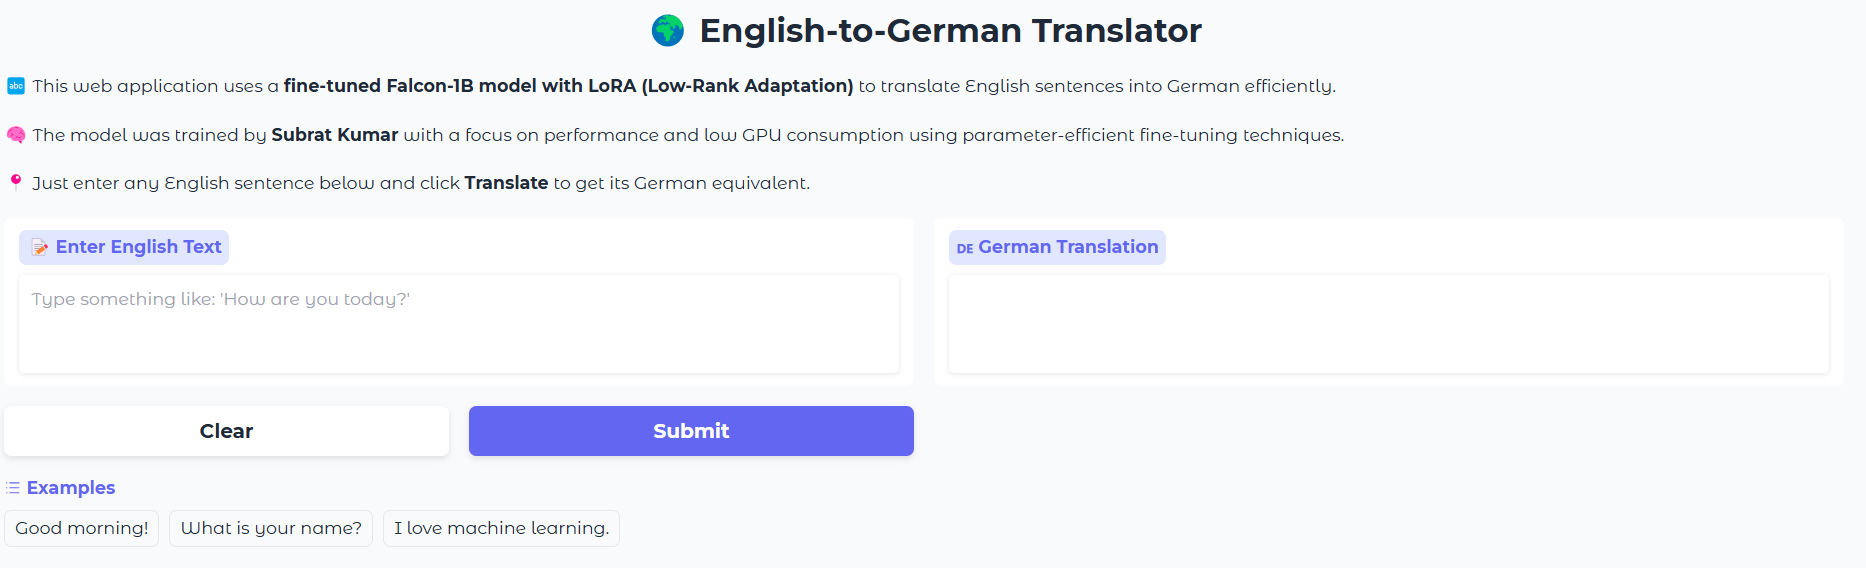

### **Challenges Faced:**  
Due to the limited dataset and smaller model size, early outputs weren’t very accurate. I noticed it sometimes repeated phrases or gave generic responses.



## 🧪 Next Steps

- Try with a larger model like `gpt2` or `falcon-rw-1b` if GPU allows
- Evaluate BLEU scores on validation outputs
- Push to Hugging Face Hub for deployment
- Extend this for other languages or tasks (summarization, chat, etc.)
- I will improve this by tweaking the **prompt format**, using **beam search**, and will adjust **temperature** for more diverse and meaningful German translations. 
- I will also consider the whole data instate of 30 parcent.
